In [1]:
using LinearAlgebra
using Plots
using Test
using Printf

#####################################
# Méthodes Quasi-Newton implémentée #
#####################################
function BFGS(sₖ, yₖ, Hₖ, Bₖ, ϕ)
    @test abs(dot(yₖ, sₖ)) > 10e-6*norm(yₖ)*norm(sₖ)
    ρₖ = 1/dot(yₖ, sₖ)
    Hₖ = (I-ρₖ*sₖ*transpose(yₖ))*Hₖ*(I-ρₖ*yₖ*transpose(sₖ)) + ρₖ*sₖ*transpose(sₖ)
    Bₖ += -Bₖ*sₖ*transpose(sₖ)*Bₖ/(dot(sₖ, Bₖ*sₖ)) + yₖ*transpose(yₖ)*ρₖ
    @test norm(Hₖ*yₖ - sₖ) < 10e-6
    @test norm(Bₖ*sₖ - yₖ) < 10e-6
    @test norm(Hₖ*Bₖ - I) < 10e-4
    return(Hₖ, Bₖ)
end

function DFP(sₖ, yₖ, Hₖ, Bₖ, ϕ)
    @test abs(dot(yₖ, sₖ)) > 10e-6*norm(yₖ)*norm(sₖ)
    ρₖ = 1/dot(yₖ, sₖ)
    Bₖ = (I-ρₖ*yₖ*transpose(sₖ))*Bₖ*(I-ρₖ*sₖ*transpose(yₖ)) + ρₖ*yₖ*transpose(yₖ)
    Hₖ += -Hₖ*yₖ*transpose(yₖ)*Hₖ/(dot(yₖ, Hₖ*yₖ)) + sₖ*transpose(sₖ)*ρₖ
    @test norm(Hₖ*yₖ - sₖ) < 10e-6
    @test norm(Bₖ*sₖ - yₖ) < 10e-6
    @test norm(Hₖ*Bₖ - I) < 10e-4
    return(Hₖ, Bₖ)
end

function SR1(sₖ, yₖ, Hₖ, Bₖ, ϕ)
    b = yₖ - Bₖ*sₖ
    @test abs(dot(b, sₖ)) > 10e-6*norm(b)*norm(sₖ)
    Bₖ += b*transpose(b)/(dot(b, sₖ))
    h = sₖ - Hₖ*yₖ
    @test abs(dot(h, yₖ)) > 10e-6*norm(yₖ)*norm(h)
    Hₖ += h*transpose(h)/(dot(h, yₖ))
    @test norm(Hₖ*yₖ - sₖ) < 10e-6
    @test norm(Bₖ*sₖ - yₖ) < 10e-6
    return(Hₖ, Bₖ)
end

function Broyden(sₖ, yₖ, Hₖ, Bₖ, ϕ)
    HBFGS, BBFGS = BFGS(sₖ, yₖ, Hₖ, Bₖ, ϕ)
    HDFP, BDFP = DFP(sₖ, yₖ, Hₖ, Bₖ, ϕ)
    Hₖ = (1-ϕ)*HDFP + ϕ*HBFGS
    Bₖ = inv(Hₖ)
    @test norm(Hₖ*yₖ - sₖ) < 10e-6
    @test norm(Bₖ*sₖ - yₖ) < 10e-6
    @test norm(Hₖ*Bₖ - I) < 10e-4
    return(Hₖ, Bₖ)
end

Broyden (generic function with 1 method)

In [2]:
# Un problème de minimisation sans contrainte est associé à une fonction, 
# son gradient et la matrice approchant la Hessienne
mutable struct problem
    fonction # Evaluation de la fonction
    gradient # Evaluation du gradient
    Hess # Evaluation de la Hessienne
end

In [3]:
function lineSearch(problem, x₀, Δ; affichage = true, maxiter = 1000, ϵ = 10e-8, update = BFGS, negCurvature = true, ϕ = 0.5)
    # initialisation
    g = problem.gradient
    k = 0
    pₖ = zeros(length(x₀))
    sₖ = zeros(length(x₀))
    yₖ = zeros(length(x₀))
    b = g(pₖ) # g(x) = Ax + b -> g(0) = b
    gₖ = g(x₀)
    Hₖ, Bₖ = I, I
    sᵩ = zeros(length(x₀))
    τᵩ = 0
    B = problem.Hess(x₀)
    NormP = []
    P = [] 
    NormB = [norm(Bₖ - B)] 
    F = [] 
    eig = []
    α = []
    G = []
    if(affichage)
        @printf("%4s %9s %9s %6s %9s %9s %9s %9s %9s \n", "k", "dₖᵗBdₖ", "gₖᵗdₖ", "αₖ", "f(xₖ)", "||pₖ||", "||B-Bₖ||", "||gₖ||", "ρₖ")
    end
    while(k <= maxiter && norm(gₖ) > ϵ)
        if(k != 0)
            Hₖ, Bₖ = update(sₖ, yₖ, Hₖ, Bₖ, ϕ)
            push!(NormB, norm(Bₖ - B))
            push!(eig, real.(eigvals(Bₖ)))
        end
        dₖ = -Hₖ*gₖ # Direction de descente
        ρₖ = 1/dot(yₖ, sₖ)
        bₖ = g(dₖ) - b
        if(abs(dot(gₖ, dₖ)) < 10e-6*norm(gₖ)*norm(dₖ) && negCurvature)
            if(dot(dₖ, bₖ) < -10e-6*norm(dₖ)*norm(bₖ))
                αₖ = 2*Δ/norm(dₖ)
            else
                dₖ = -gₖ
                bₖ = g(dₖ) - b
                if(dot(dₖ, bₖ) < -10e-6*norm(dₖ)*norm(bₖ))
                    αₖ = 2*Δ/norm(dₖ)
                else
                    αₖ = -dot(gₖ, dₖ)/dot(dₖ, bₖ)
                end
            end
        elseif(dot(dₖ, bₖ) <= 10e-6*norm(dₖ)*norm(bₖ) && negCurvature)
            αₖ = -2*Δ*sign(dot(gₖ, dₖ))/norm(dₖ)
        else
            αₖ = -dot(gₖ, dₖ)/dot(dₖ, bₖ)
        end
        push!(α, αₖ)
        sₖ = αₖ*dₖ
        pₖ += sₖ
        if(affichage)
            @printf("%4d %8.1e %8.1e %8.1e %8.1e %8.1e %8.1e %8.1e %8.1e \n", k, dot(dₖ, B*dₖ), dot(gₖ, dₖ), αₖ, 
                problem.fonction(x₀ + pₖ), norm(pₖ), norm(Bₖ - B), norm(gₖ), ρₖ)
        end
        yₖ = g(x₀ + pₖ) - gₖ
        gₖ += yₖ # Mise à jour du gradient au nouveau point courant (gₖ₊₁ = yₖ₊₁ + gₖ)  
        if(norm(pₖ) >= Δ)
            # Si p traverse la région de confiance on trouve le réel τ ∈ [0, 1]
            # tel que ||s1 + s2 + ... + sk-1 + τ*sₖ|| = Δ
            pₖ += -sₖ # calcul de s1 + s2 + ... + sk-1 (on retire sₖ à pₖ)
            # Résolution de l'équation du second ordre ||pₙ + τ*sₙ||² = Δ²
            # <=> (||pₙ₋₁||² - Δ²) + 2*τ*dot(pₙ₋₁, sₙ) + τ²*||sₙ||² = 0
            a, b, c = dot(sₖ, sₖ), 2*dot(pₖ, sₖ), dot(pₖ, pₖ) - Δ^2
            δ = b^2 - 4*a*c
            τ = (-b + sqrt(δ))/(2*a)
            # Descente de gradient
            sᵩ = -gₖ/norm(gₖ)
            a, b = dot(sᵩ, sᵩ), 2*dot(pₖ, sᵩ)
            δ = b^2 - 4*a*c
            τᵩ = (-b + sqrt(δ))/(2*a)
            # Mise à jour de pₖ
            if(problem.fonction(x₀ + τᵩ*sᵩ + pₖ) < problem.fonction(x₀ + τ*sₖ + pₖ))
                @printf("%67s %8.1e \n", "Descente de gradient meilleure que BFGS qui nous donnait : f(x*) = ", 
                    problem.fonction(x₀ + τ*sₖ + pₖ))
                pₖ += τᵩ*sᵩ
            else
                pₖ += τ*sₖ
            end
            # Sauvegarde de l'évolution de la méthode pour affichage graphique
            push!(F, problem.fonction(x₀ + pₖ))
            push!(NormP, norm(pₖ))
            push!(P, pₖ)  
            if(affichage)
               @printf("%35s %8s %8.1e %9s %8.1e \n", "sortie de la région de confiance : ", "f(x*) = ", 
                    problem.fonction(x₀ + pₖ), "||p*|| = ", norm(pₖ)) 
            end
            return(pₖ, NormP, k, P, NormB, F, eig, α, G)
        end
        # Sauvegarde de l'évolution de la méthode pour affichage graphique
        push!(F, problem.fonction(x₀ + pₖ))
        push!(NormP, norm(pₖ))
        push!(P, pₖ) 
        push!(G, norm(gₖ))
        k += 1
    end
    return(pₖ, NormP, k - 1, P, NormB, F, eig, α, G)
end

lineSearch (generic function with 1 method)

In [14]:
function CG(problem, x₀, Δ; maxiter = 1000, ϵ = 10e-8, affichage = true, negCurvature = true, CGtype = 1)
    A = problem.Hess(x₀)
    rₖ = problem.gradient(x₀)
    pₖ = -rₖ
    βₖ = 0
    k = 0
    xₖ = x₀
    X = []
    normP = []
    F = []
    α = []
    n = length(x₀)
    G = []
    orthogo = []
    if(affichage)
        @printf("%4s %9s %6s %9s %9s %9s %9s \n", "k", "gₖᵗdₖ", "αₖ", "f(xₖ)", "||pₖ||", "||gₖ||", "β")
    end
    while(norm(rₖ) > ϵ && k <= maxiter)
        if(k > 0)
            C = zeros(n, k+1)
            C[1:n, 1:k] = P
            P = C
            P[1:n, k+1] = pₖ/norm(pₖ)  
            ### Calcul de la perte d'orthogonalité
            U = P'*A*P
            D = Diagonal(U[diagind(U)])
            for i = 1:(k+1)
                for j = 1:i
                    U[i, j] = 0
                end
            end
            S = inv(D + U)*U
            push!(orthogo, norm(S))
        else
            global P = pₖ/norm(pₖ)
        end
        bₖ = A*pₖ
        if(dot(pₖ, bₖ) <= ϵ && negCurvature)
            if(dot(rₖ, pₖ) < ϵ)
                αₖ = 2*Δ/norm(pₖ) # On force à sortir de la région de confiance
            else
                αₖ = -2*Δ/norm(pₖ)
            end
        else
            αₖ = -dot(rₖ, pₖ)/dot(pₖ, bₖ)
        end
        push!(α, αₖ)
        xₖ += αₖ*pₖ
        if(affichage)
            @printf("%4d %8.1e %8.1e %8.1e %8.1e %8.1e %8.1e \n", k, dot(pₖ, rₖ), αₖ, problem.fonction(xₖ), norm(xₖ - x₀), norm(rₖ), βₖ)
        end
        if(norm(xₖ) >= Δ)
            # Si p traverse la région de confiance on trouve le réel τ ∈ [0, 1]
            # tel que ||s1 + s2 + ... + sk-1 + τ*sₖ|| = Δ
            sₖ = αₖ*pₖ
            xₖ += -sₖ # calcul de s1 + s2 + ... + sk-1 (on retire sₖ à pₖ)
            # Résolution de l'équation du second ordre ||xₙ₋₁ + τ*αₖ*pₖ||² = Δ²
            # <=> (||xₙ₋₁||² - Δ²) + 2*τ*dot(xₙ₋₁, αₖ*pₖ) + τ²*||αₖ*pₖ||² = 0
            a = dot(sₖ, sₖ)
            b = 2*dot(xₖ, sₖ)
            c = dot(xₖ, xₖ) - Δ^2
            δ = b^2 - 4*a*c
            τ = (-b + sqrt(δ))/(2*a)
            # Mise à jour de pₖ
            xₖ += τ*sₖ
            k += 1
            push!(normP, norm(xₖ - x₀))
            push!(F, problem.fonction(xₖ))
            if(affichage)
               @printf("%35s %8s %8.1e %9s %8.1e \n", "sortie de la région de confiance : ", "f(x*) = ", 
                    problem.fonction(xₖ), "||p*|| = ", norm(xₖ - x₀)) 
            end
            return(xₖ - x₀, k, normP, F, α, G)
        end
        yₖ = αₖ * bₖ
        if(CGtype == 1)
            rₖ = problem.gradient(xₖ)
            βₖ = dot(rₖ, bₖ)/dot(pₖ, bₖ)
        elseif(CGtype == 2)
            βₖ = 1/dot(rₖ, rₖ)
            rₖ = problem.gradient(xₖ)
            βₖ *= dot(rₖ, rₖ)
        elseif(CGtype == 3)
            βₖ = 1/dot(rₖ, rₖ)
            rₖ = problem.gradient(xₖ)
            βₖ *= dot(rₖ, yₖ)
        elseif(CGtype == 4)
            βₖ = -1/dot(pₖ, rₖ)
            rₖ = problem.gradient(xₖ)
            βₖ *= dot(rₖ, rₖ)
        elseif(CGtype == 5)
            βₖ = -1/dot(pₖ, rₖ)
            rₖ = problem.gradient(xₖ)
            βₖ *= dot(rₖ, yₖ)
        elseif(CGtype == 6)
            βₖ = 1/dot(pₖ, yₖ)
            rₖ = problem.gradient(xₖ)
            βₖ *= dot(rₖ, rₖ)
        elseif(CGtype == 7)
            rₖ = problem.gradient(xₖ)
            βₖ = dot(rₖ/dot(pₖ, yₖ), yₖ - 2*pₖ*dot(yₖ, yₖ) / dot(pₖ, yₖ))
        end            
        pₖ = -rₖ + βₖ*pₖ
        k += 1
        push!(F, problem.fonction(xₖ))
        push!(normP, norm(xₖ - x₀))
        push!(G, norm(rₖ))
    end
    return(xₖ - x₀, k, normP, F, α, G, orthogo)
end

CG (generic function with 1 method)

In [10]:
using LinearOperators

function LMlineSearch(problem, x₀, Δ; mem = 5, affichage = true, maxiter = 1000, ϵ = 10e-8, update = BFGS, scaling = false, negCurvature = true, ϕ = 0.5)
    # initialisation
    g = problem.gradient
    k = 0
    n = length(x₀)
    pₖ = zeros(n)
    yₖ = zeros(n)
    sₖ = zeros(n)
    B = problem.Hess(x₀)
    b = g(pₖ) # g(x) = Ax + b -> g(0) = b
    gₖ = g(x₀)
    sᵩ = zeros(length(x₀))
    τᵩ = 0
    Hₖ = InverseLBFGSOperator(n, mem, scaling = scaling, diag_scaling = scaling)
    A = problem.Hess(x₀)
    NormP = []
    F = []
    α = []
    n = length(x₀)
    G = []
    orthogo = []
    if(affichage)
        @printf("%4s %9s %9s %6s %9s %9s %9s %9s \n", "k", "dₖᵗBdₖ", "gₖᵗdₖ", "αₖ", "f(xₖ)", "||pₖ||", "||gₖ||", "ρₖ")
    end
    while(k <= maxiter && norm(gₖ) > ϵ)
        dₖ = -Hₖ*gₖ # Direction de descente
        if(k > 0)
            C = zeros(n, k+1)
            C[1:n, 1:k] = P
            P = C
            P[1:n, k+1] = dₖ/norm(dₖ)
            ### Calcul de la perte d'orthogonalité
            U = P'*A*P
            D = Diagonal(U[diagind(U)])
            for i = 1:(k+1)
                for j = 1:i
                    U[i, j] = 0
                end
            end
            S = inv(D + U)*U
            push!(orthogo, norm(S))
        else
            global P = dₖ/norm(dₖ)
        end
        bₖ = g(dₖ) - b
        if(dot(dₖ, bₖ) <= 10e-6*norm(dₖ)*norm(bₖ) && negCurvature)
            αₖ = -2*Δ*sign(dot(gₖ, dₖ))/norm(dₖ)
        else
            αₖ = -dot(gₖ, dₖ)/dot(dₖ, bₖ)
        end
        push!(α, norm(αₖ))
        sₖ = αₖ*dₖ
        pₖ += sₖ
        ρₖ = 1/dot(sₖ, yₖ)
        if(affichage)
            @printf("%4d %8.1e %8.1e %8.1e %8.1e %8.1e %8.1e %8.1e \n", k, dot(dₖ, B*dₖ), dot(gₖ, dₖ), αₖ, 
                problem.fonction(x₀ + pₖ), norm(pₖ), norm(gₖ), ρₖ)
        end
        yₖ = g(x₀ + pₖ) - gₖ
        # Mise à jour de la liste des yₖ et sₖ
        #if(k%mem == 0 && k!=0)
        #    reset!(Hₖ)
        #else
        push!(Hₖ, sₖ, yₖ)
        #end
        gₖ += yₖ # Mise à jour du gradient au nouveau point courant (gₖ₊₁ = yₖ₊₁ + gₖ) 
        if(norm(pₖ) >= Δ)
            # Si p traverse la région de confiance on trouve le réel τ ∈ [0, 1]
            # tel que ||s1 + s2 + ... + sk-1 + τ*sₖ|| = Δ
            pₖ += -sₖ # calcul de s1 + s2 + ... + sk-1 (on retire sₖ à pₖ)
            # Résolution de l'équation du second ordre ||pₙ + τ*sₙ||² = Δ²
            # <=> (||pₙ₋₁||² - Δ²) + 2*τ*dot(pₙ₋₁, sₙ) + τ²*||sₙ||² = 0
            a, b, c = dot(sₖ, sₖ), 2*dot(pₖ, sₖ), dot(pₖ, pₖ) - Δ^2
            δ = b^2 - 4*a*c
            τ = (-b + sqrt(δ))/(2*a)
            # Descente de gradient
            sᵩ = -gₖ/norm(gₖ)
            a, b = dot(sᵩ, sᵩ), 2*dot(pₖ, sᵩ)
            δ = b^2 - 4*a*c
            τᵩ = (-b + sqrt(δ))/(2*a)
            # Mise à jour de pₖ
            if(problem.fonction(x₀ + τᵩ*sᵩ + pₖ) < problem.fonction(x₀ + τ*sₖ + pₖ))
                @printf("%67s %8.1e \n", "Descente de gradient meilleure que BFGS qui nous donnait : f(x*) = ", 
                    problem.fonction(x₀ + τ*sₖ + pₖ))
                pₖ += τᵩ*sᵩ
            else
                pₖ += τ*sₖ
            end
            # Sauvegarde de l'évolution de la méthode pour affichage graphique
            push!(F, problem.fonction(x₀ + pₖ))
            push!(NormP, norm(pₖ))
            push!(G, norm(gₖ))
            if(affichage)
               @printf("%35s %8s %8.1e %9s %8.1e \n", "sortie de la région de confiance : ", "f(x*) = ", 
                    problem.fonction(x₀ + pₖ), "||p*|| = ", norm(pₖ)) 
            end
            return(pₖ, NormP, k, F, α, G, orthogo)
        end
        # Sauvegarde de l'évolution de la méthode pour affichage graphique
        push!(F, problem.fonction(x₀ + pₖ))
        push!(NormP, norm(pₖ))
        push!(G, norm(gₖ))
        k += 1
    end
    return(pₖ, NormP, k-1, F, α, G, orthogo, P)
end

LMlineSearch (generic function with 1 method)

In [15]:
N = 300
A = rand(30000:400000, N, N)
b = rand(N)
A = A' * A
g(x) = A*x + b
f(x) = 0.5*dot(x, A*x) + dot(b, x)
B(x) = A
quad = problem(f, g, B)
# x₀ = -A\b - 10e-4*ones(N)
x₀ = zeros(N)
println(norm(inv(A))*norm(A))

Δ = Inf
sol, k₁, normP₁, F₁, α, G₁, ortho₁ = CG(quad, x₀, Δ, affichage = false, negCurvature = false , CGtype = 1,maxiter = 3*N)
sol, k₂, normP₂, F₂, α, G₂, ortho₂ = CG(quad, x₀, Δ, affichage = false, negCurvature = false , CGtype = 2,maxiter = 3*N)
sol, k₃, normP₃, F₃, α, G₃, ortho₃ = CG(quad, x₀, Δ, affichage = false, negCurvature = false , CGtype = 3,maxiter = 3*N)
sol, k₄, normP₄, F₄, α, G₄, ortho₄ = CG(quad, x₀, Δ, affichage = false, negCurvature = false , CGtype = 4,maxiter = 3*N)
sol, k₅, normP₅, F₅, α, G₅, ortho₅ = CG(quad, x₀, Δ, affichage = false, negCurvature = false , CGtype = 5,maxiter = 3*N)
sol, k₆, normP₆, F₆, α, G₆, ortho₆ = CG(quad, x₀, Δ, affichage = false, negCurvature = false , CGtype = 6,maxiter = 3*N)
sol, k₇, normP₇, F₇, α, G₇, ortho₇ = CG(quad, x₀, Δ, affichage = false, negCurvature = false , CGtype = 7,maxiter = 3*N)
sol, normP₈, k₈, F₈, α, G₈, ortho₈ = LMlineSearch(quad, x₀, Δ, mem = 1, affichage = false, negCurvature = false ,maxiter = 3*N)
sol, normP₉, k₉, F₉, α, G₉, ortho₉ = LMlineSearch(quad, x₀, Δ, mem = 2, affichage = false, negCurvature = false ,maxiter = 3*N)

3.875920725427626e8


([1.31064e-9, 3.71498e-9, -4.7806e-10, -1.68473e-9, -1.08388e-9, 3.31074e-10, -2.05116e-9, -1.14665e-9, -5.14876e-10, 1.45588e-9  …  -1.03086e-9, -1.43492e-9, -1.33652e-10, 2.14069e-9, 6.2381e-10, -1.29122e-9, -2.03163e-9, 6.6122e-10, -9.97058e-10, 3.24529e-9], Any[3.32391e-15, 1.61268e-12, 3.26788e-12, 5.5378e-12, 8.22001e-12, 1.11726e-11, 1.43678e-11, 1.43869e-11, 1.8478e-11, 2.32796e-11  …  2.51407e-8, 2.51407e-8, 2.51407e-8, 2.51407e-8, 2.51407e-8, 2.51407e-8, 2.51407e-8, 2.51407e-8, 2.51407e-8, 2.51407e-8], 900, Any[-1.72239e-14, -4.21819e-12, -7.72856e-12, -1.16228e-11, -1.55887e-11, -1.94804e-11, -2.33163e-11, -2.33384e-11, -2.78564e-11, -3.27917e-11  …  -3.72507e-9, -3.72507e-9, -3.72507e-9, -3.72507e-9, -3.72507e-9, -3.72507e-9, -3.72507e-9, -3.72507e-9, -3.72507e-9, -3.72507e-9], Any[3.20728e-16, 2.30671e-13, 2.74076e-13, 2.93136e-13, 3.02641e-13, 3.22048e-13, 2.97973e-13, 1.40398e-15, 5.92925e-14, 3.25251e-13  …  3.03383e-16, 1.13381e-15, 3.03384e-16, 1.13381e-15, 3.03384e-1

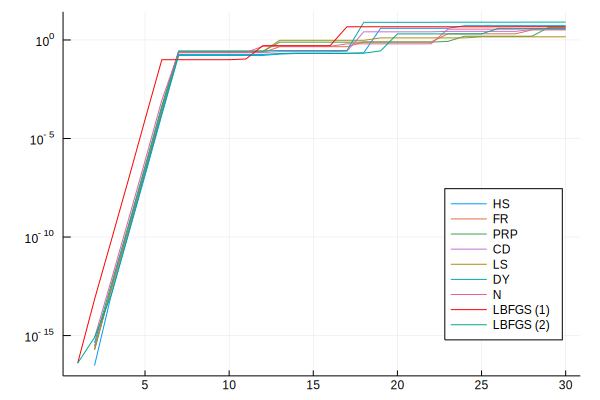

In [27]:
plot(2:30, ortho₁[1:29], label = "HS", legend = :bottomright, yaxis = :log)
plot!(2:30, ortho₂[1:29], label = "FR")
plot!(2:30, ortho₃[1:29], label = "PRP")
plot!(2:30, ortho₄[1:29], label = "CD")
plot!(2:30, ortho₅[1:29],label = "LS")
plot!(2:30, ortho₆[1:29],label = "DY")
plot!(2:30, ortho₇[1:29],label = "N")
plot!(1:30, ortho₈[1:30], label="LBFGS (1)", color = :red)
plot!(1:30, ortho₉[1:30], label="LBFGS (2)")

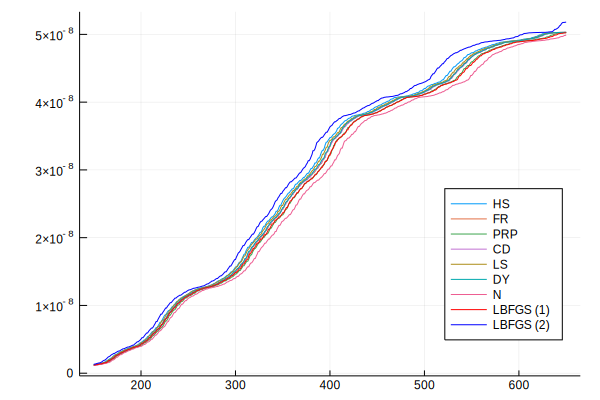

In [30]:
plot(150:650, normP₁[150:650], label = "HS", legend = :bottomright)
plot!(150:650, normP₂[150:650], label = "FR")
plot!(150:650, normP₃[150:650], label = "PRP")
plot!(150:650, normP₄[150:650], label = "CD")
plot!(150:650, normP₅[150:650],label = "LS")
plot!(150:650, normP₆[150:650],label = "DY")
plot!(150:650, normP₇[150:650],label = "N")
plot!(150:650, normP₈[151:651], label="LBFGS (1)", color = :red)
plot!(150:650, normP₉[151:651], label="LBFGS (2)", color = :blue)

In [21]:
length(ortho₈)

900

In [22]:
k₈

900